In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

#from pandas_profiling import ProfileReportofileReport

import warnings
warnings.filterwarnings('ignore')

In [63]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_positive_rate,true_positive_rate,count


from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from xgboost import XGBRegressor,XGBClassifier
from catboost import CatBoostClassifier
import shap

from category_encoders.target_encoder import TargetEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from tqdm.notebook import tqdm
from collections import defaultdict 

In [3]:
df = pd.read_csv("data/compas-scores-raw.csv")


In [4]:
df = pd.read_csv("data/compas-scores-raw.csv")

df["Score"] = df["DecileScore"]

# df.loc[df["DecileScore"] > 7, "Score"] = 2
# df.loc[(df["DecileScore"] > 4) & (df["DecileScore"] < 8), "Score"] = 1
# df.loc[df["DecileScore"] < 5, "Score"] = 0

df.loc[df["DecileScore"] > 4, "Score"] = 1
df.loc[df["DecileScore"] <= 4, "Score"] = 0


cols = [
    "Person_ID",
    "AssessmentID",
    "Case_ID",
    "LastName",
    "FirstName",
    "MiddleName",
    "DateOfBirth",
    "ScaleSet_ID",
    "Screening_Date",
    "RecSupervisionLevel",
    "Agency_Text",
    "AssessmentReason",
    "Language",
    "Scale_ID",
    "IsCompleted",
    "IsDeleted",
    "AssessmentType",
    "DecileScore",
]


df = df.drop(columns=cols)

possible_targets = ["RawScore", "ScoreText", "Score"]

X = df.drop(columns=possible_targets)
y = df[["Score"]]

In [5]:
for col in X.columns:
    print(len(X[col].unique()))

2
9
2
7
6
7
4
3


In [6]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
def fit_predict(modelo, enc, data, target, test):
    pipe = Pipeline([("encoder", enc), ("model", modelo)])
    pipe.fit(data, target)
    return pipe.predict(test)


def auc_group(model, data, y_true, dicc, group: str = "", min_samples: int = 500):

    aux = data.copy()
    aux["target"] = y_true
    cats = aux[group].value_counts()
    cats = cats[cats > min_samples].index.tolist()
    cats = cats + ["all"]

    if len(dicc) == 0:
        dicc = defaultdict(list, {k: [] for k in cats})

    for cat in cats:
        if cat != "all":
            aux2 = aux[aux[group] == cat]
            preds = model.predict_proba(aux2.drop(columns="target"))[:, 1]
            truth = aux2["target"]
            dicc[cat].append(roc_auc_score(truth, preds))
        elif cat == "all":
            dicc[cat].append(roc_auc_score(y_true, model.predict_proba(data)[:, 1]))
        else:
            pass

    return dicc



In [48]:
def metric_calculator(
    modelo, data: pd.DataFrame, truth: pd.DataFrame,col:str, group1: str, group2: str
):
    aux = data.copy()
    aux['target'] = truth

    
    g1 = data[data[col]==group1]
    g2 = data[data[col]==group2]

    modelo.predict(g1)

    
    g1_true = aux[aux[col]==group1].target
    g2_true = aux[aux[col]==group2].target
    
    p1 = modelo.predict(g1)
    p2 = modelo.predict(g2)
    
    #I obtain the confusion matrix
    cm=confusion_matrix(p1, g1_true)

    
    #  https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    
    return np.diff(TPR)[0]

# Experiment

In [94]:
# Experiment parameters
COL = "Ethnic_Code_Text"
GROUP1 = "Caucasian"
GROUP2 = "African-American"

# To scale the plot
SCALING = True

# To modify the metric update metric calculator function

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.])

In [110]:
auc = {}
metrica = []
#param = [0, 1, 2, 5, 10, 20, 50, 100]
param = np.linspace(0, 19, 100)
for m in tqdm(param):
    encoder = MEstimateEncoder(m=m)
    # encoder = TargetEncoder(smoothing=m)
    # encoder = LeaveOneOutEncoder(sigma=m)

    model = LogisticRegression()
    #model = GradientBoostingClassifier()

    pipe = Pipeline([("encoder", encoder), ("model", model)])
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_te)

    metrica.append(
        metric_calculator(
            modelo=pipe,
            data=X_tr,
            truth=y_tr,
            col=COL,
            group1=GROUP1,
            group2=GROUP2,
        )
    )
    auc = auc_group(
            model=pipe, data=X_tr, y_true=y_tr, dicc=auc, group=COL
        )
    

# Results formatting
res = pd.DataFrame(index = param)
res['fairness_metric'] = metrica
res['auc_'+GROUP1] = auc[GROUP1]
res['auc_'+GROUP2] = auc[GROUP2]
if SCALING:
    ress = pd.DataFrame(StandardScaler().fit_transform(res),columns = res.columns,index=res.index)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

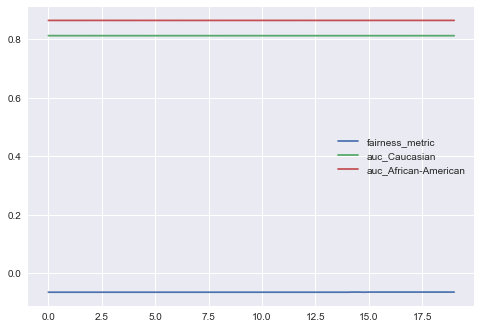

In [111]:
res.plot()

<AxesSubplot:>

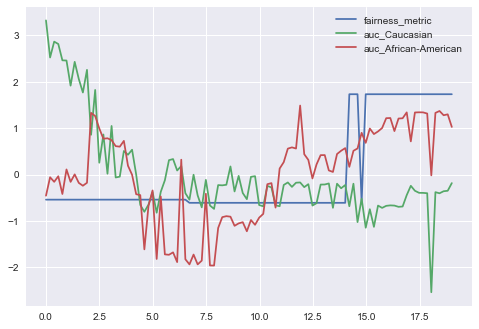

In [112]:
ress.plot()

<AxesSubplot:>

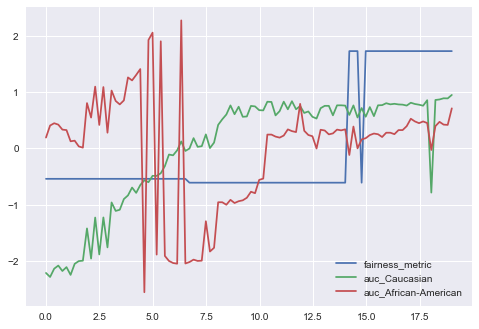

In [109]:
res.plot()